In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels
import bumps

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import sas

In [3]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual weight percentages
data = np.loadtxt('../../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
actual_stdev = {}
actual_vol = {}
actual_stdev_vol = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[key] = act
    actual_stdev[key] = stdev
    actual_vol[key] = act_vol
    actual_stdev_vol[key] = stdev_vol
    
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       'Polystyrene-D8':6.464, # density 1.13
       'Polystyrene-H8':1.426}


In [4]:
data_dir = '../../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

Loading polystyrene fit information.

In [5]:
background_files = [file for file in os.listdir('../../data/sans/PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

In [6]:
power_law_fit_info = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_exp_95 = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])

In [7]:
guinier_porod_fit = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = ps_scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(ps_scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))

In [8]:
avg_rg = np.average([x[0] for x in rgs.values()])
max_rg = np.max([x[1][1] for x in rgs.values()])
min_rg = np.min([x[1][0] for x in rgs.values()])

In [9]:
avg_scale = np.average([x[0] for y, x in ps_scales.items() if y in rgs.keys()])
max_scale = np.average([x[1][1] for y, x in ps_scales.items() if y in rgs.keys()])
min_scale = np.average([x[1][0] for y, x in ps_scales.items() if y in rgs.keys()])


Loading the Porod analysis results, we will only utilize the previously determined background values to minimize the fitting here.

In [10]:
porod_files = [file for file in os.listdir('../../data/sans/Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../../data/sans/Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 

Loading fit parameters from the results directory.

In [14]:
results_direct = '../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/'

fit_keys = []
fit_polar_radius = {}
fit_equatorial_radius = {}
fit_cylinder_radius = {}
fit_scale_ratio = {}
fit_cp_scale = {}
fit_cylinder_length = {}

for file in [file for file in os.listdir(results_direct) if '.csv' in file]:
    data_read = np.loadtxt(results_direct+file, delimiter=',', dtype='str')
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for label, x, dx in data_read:
        x = float(x)
        dx = float(dx)
        if 'radius' in label:
            if 'cylinder' in label:
                fit_cylinder_radius[key] = (x,dx)
            elif 'polar' in label:
                fit_polar_radius[key] = (x,dx)
            elif 'equatorial' in label:
                fit_equatorial_radius[key] = (x,dx)
        elif 'cp scale' in label:
            fit_cp_scale[key] = (x,dx)
        elif 'scale ratio' in label:
            fit_scale_ratio[key] = (x,dx)
        elif 'length' in label:
            fit_cylinder_length[key] = (x,dx)
            
    


Convenient dictionaries for plotting.

In [15]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    10.0: 'deeppink',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'forestgreen'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'forestgreen',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

for key in names.keys():
    if key in actual.keys():
        frac = actual[key]
    else:
        frac = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key] + '\nfrom ' + solvent_names[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]


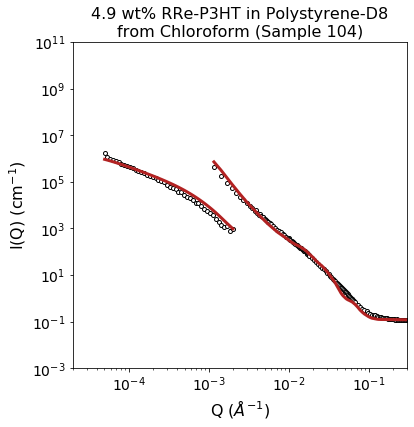

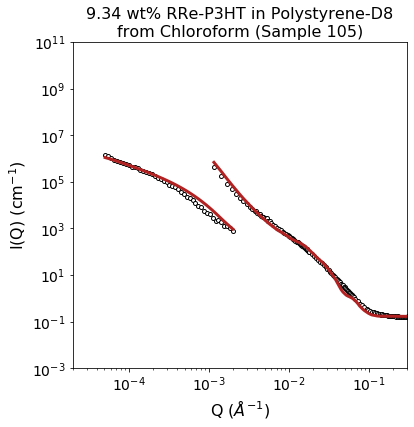

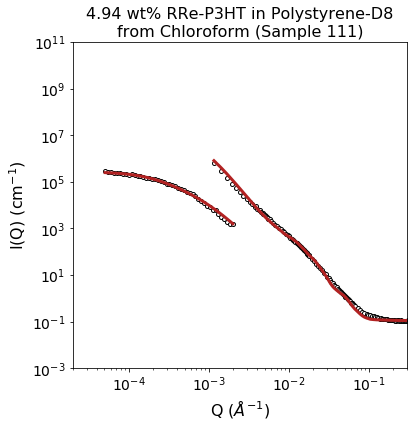

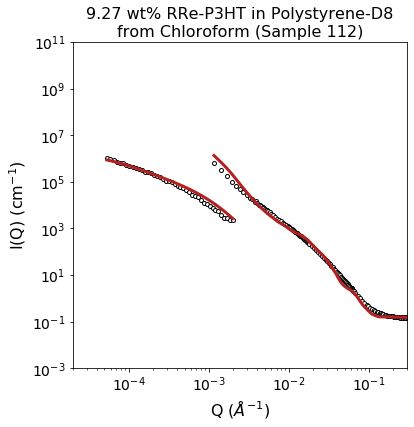

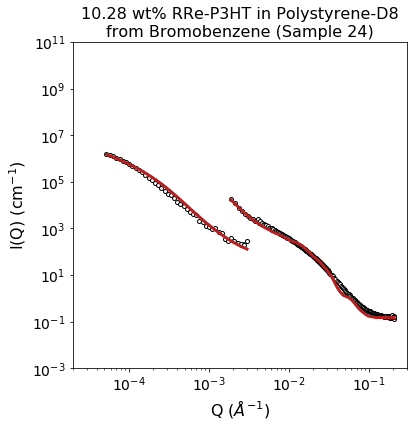

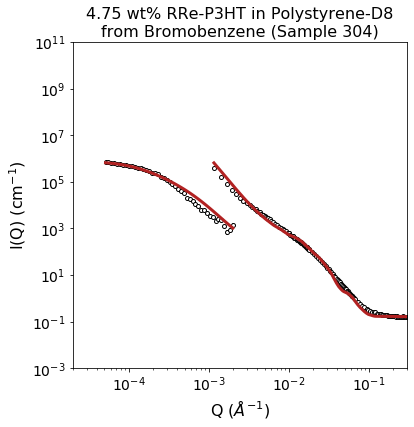

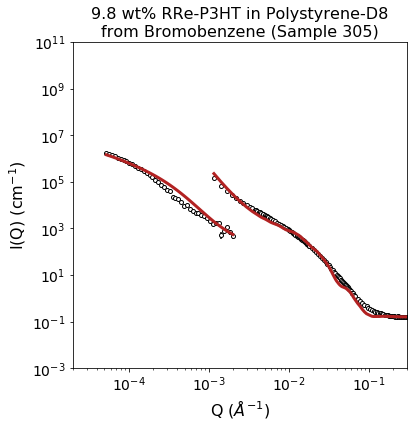

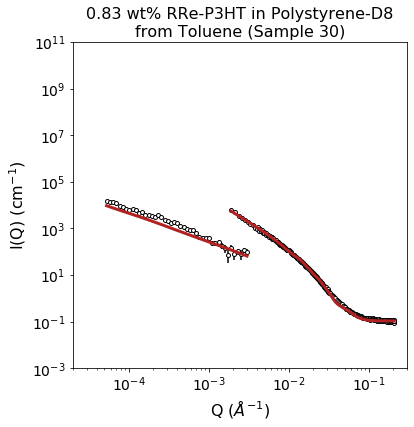

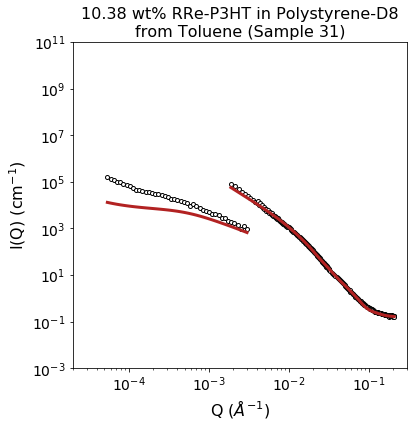

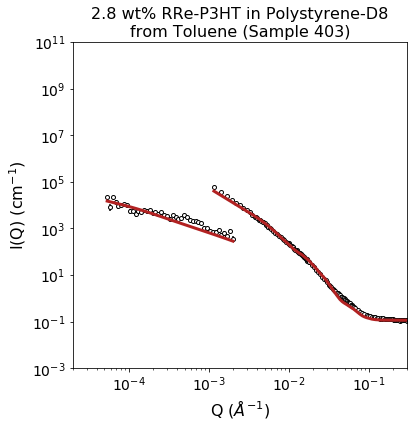

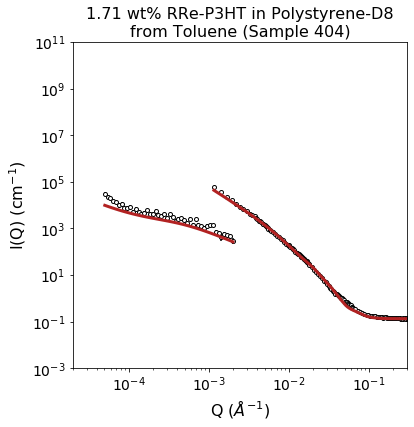

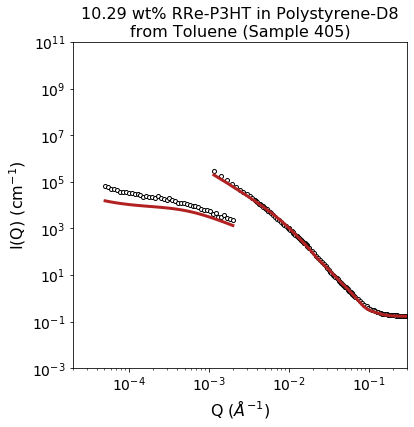

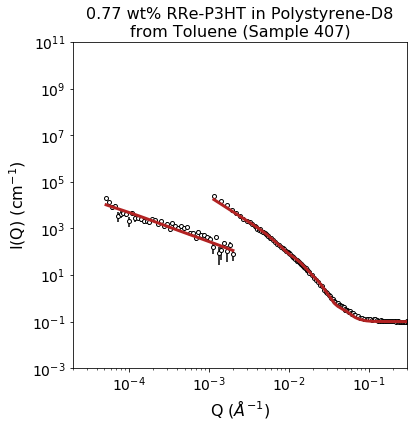

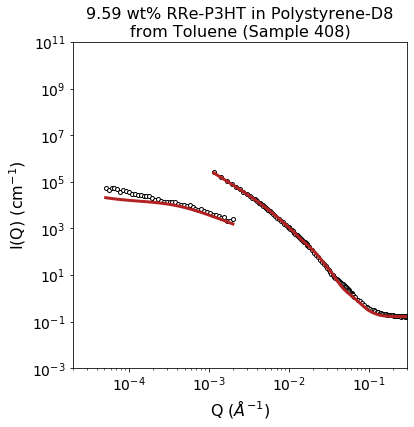

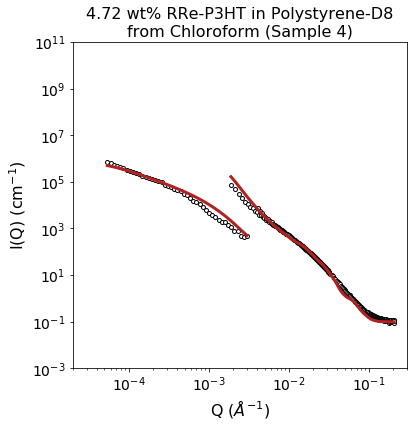

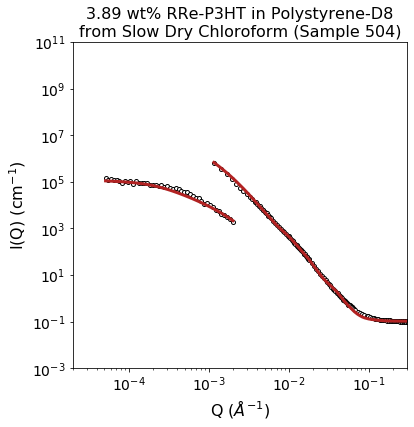

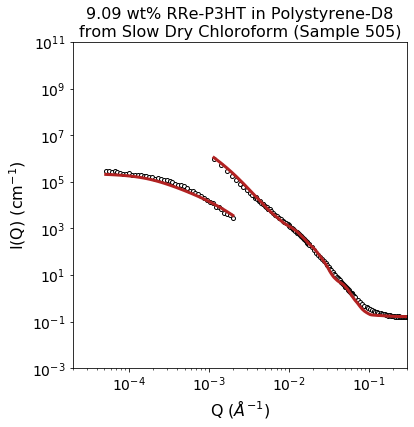

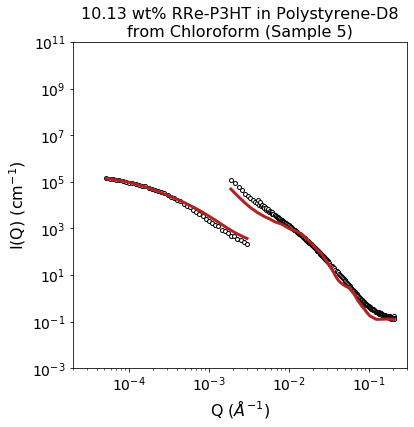

In [16]:
os.makedirs('../../data/sans/Sample_Fitting/fitting_figures/ps_ellipsoid_cylinder_lm', exist_ok=True)

for key in fit_keys:
#for key in [31]:
    
    plt.figure(figsize=(6,6))
    
    kernel = load_model('guinier_porod+ellipsoid+cylinder')

    vol = actual_vol[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev_vol[key]/100
    
    # model parameters
    
    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')

    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')

    scale_ratio = Parameter(fit_scale_ratio[key][0], name=str(key) + ' B scale ratio').range(0,1)
    scale_normal = bumps.bounds.Normal(mean=vol, std=vol_stdev)
    
    if key in fit_cp_scale.keys():
        cp_scale = Parameter(fit_cp_scale[key][0], name=str(key) + ' cp scale', bounds=scale_normal)
    else:
        cp_scale = Parameter(vol, name=str(key) + ' cp scale', bounds=scale_normal)
    
    B_scale = scale_ratio * cp_scale

    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')

    B_radius_polar = Parameter(fit_polar_radius[key][0], limits=[0,inf], name=str(key) + ' ellipsoid polar radius').range(100,200000)
    B_radius_polar_pd = Parameter(0.5, name = str(key) + ' ellipsoid polar radius pd')
    B_radius_polar_pd_n = Parameter(200, name = str(key) + ' ellipsoid polar radius pd n')
    B_radius_polar_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid polar radius pd nsigma') 
    
    B_radius_equatorial = Parameter(fit_equatorial_radius[key][0], limits=[0,inf], name=str(key) + ' ellipsoid equatorial radius').range(100,200000)
    B_radius_equatorial_pd = Parameter(0.5, name = str(key) + ' ellipsoid equatorial radius pd')
    B_radius_equatorial_pd_n = Parameter(200, name = str(key) + ' ellipsoid equatorial radius pd n')
    B_radius_equatorial_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid equatorial radius pd nsigma') 
    
    C_scale = (1-scale_ratio) * cp_scale
    
    C_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    C_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
        
    C_radius = Parameter(fit_cylinder_radius[key][0], limits=[0,inf], name = str(key) + ' cylinder radius').range(10,1000)
    C_radius_pd  = Parameter(0.2, name = str(key) + ' cylinder radius pd')
    C_radius_pd_n = Parameter(200, name = str(key) + ' cylinder radius pd n')
    C_radius_pd_nsigma = Parameter(8, name = str(key) + ' cylinder radius pd nsigma')

    C_length = Parameter(fit_cylinder_length[key][0], limits=[0,inf], name = str(key) + ' cylinder length').range(10000,300000)
    #C_length = Parameter(200000, limits=[0,inf], name = str(key) + ' length')
    C_length_pd  = Parameter(0, name = str(key) + ' length pd')
    C_length_pd_n = Parameter(200, name = str(key) + ' length pd n')
    C_length_pd_nsigma = Parameter(8, name = str(key) + ' length pd nsigma')
   

    # setting up the combined model for fitting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius_polar = B_radius_polar,
        B_radius_polar_pd_type = 'lognormal',
        B_radius_polar_pd = B_radius_polar_pd,
        B_radius_polar_pd_n = B_radius_polar_pd_n,
        B_radius_polar_pd_nsigma = B_radius_polar_pd_nsigma,
        B_radius_equatorial = B_radius_equatorial,
        B_radius_equatorial_pd_type = 'lognormal',
        B_radius_equatorial_pd = B_radius_equatorial_pd,
        B_radius_equatorial_pd_n = B_radius_equatorial_pd_n,
        B_radius_equatorial_pd_nsigma = B_radius_equatorial_pd_nsigma,
        C_scale = C_scale,
        C_sld = C_sld,
        C_sld_solvent = C_sld_solvent,
        C_radius = C_radius,
        C_radius_pd_type='lognormal',
        C_radius_pd = C_radius_pd,
        C_radius_pd_n = C_radius_pd_n,
        C_radius_pd_nsigma = C_radius_pd_nsigma,
        C_length = C_length,
        C_length_pd_type='lognormal',
        C_length_pd = C_length_pd,
        C_length_pd_n = C_length_pd_n,
        C_length_pd_nsigma = C_length_pd_nsigma,
    )
    
    sans = sans_data[key]
    sans.dx = sans.dx - sans.dx
    plt.errorbar(sans.x, sans.y, yerr=sans.dy, fmt='o', c='black', zorder=1, ms=4, mfc='white', mec='black')
    
    usans = usans_data[key]
    plt.errorbar(usans.x, usans.y, yerr=usans.dy, fmt='o', c='black', zorder=1, ms=4, mfc='white', mec='black')
    
    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    sans_problem=FitProblem(sans_experiment)
    usans_problem=FitProblem(usans_experiment)
    
    plt.plot(sans.x, sans_problem.fitness.theory(), c='firebrick', linewidth=3, zorder=10)
    plt.plot(usans.x, usans_problem.fitness.theory(), c='firebrick', linewidth=3, zorder=10)

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
    plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim(1e-03, 1e11)
    plt.xlim(0.00002, 0.3)

    plt.title(full_names[key] + ' (Sample ' + str(key) + ')', fontsize=16)

    plt.show()
    plt.tight_layout()
    plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/ps_ellipsoid_cylinder_lm/CMW' + str(key) + '_PS_Ellipsoid_Cylinder_LMFit.png', dpi=400)
    plt.close()


